In [1]:
import urllib
import zipfile
import os
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt

2023-09-06 19:09:55.271479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 19:09:56.657189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
data_dir = Path('../data/')
data_dir.mkdir(exist_ok=True, parents=True)
if not data_dir.exists():
  urllib.request.urlretrieve('https://docs.google.com/uc?export=download&id=1-ZqL_1cqWeG6LsRAB0TwiddW8TgQ-q70', data_dir/'Denoising_Data.zip')
  with zipfile.ZipFile(data_dir / 'Denoising_Data.zip', 'r') as zip_ref:
     zip_ref.extractall(data_dir)

In [3]:
# load training data, used to update CNN weights
# 2000 30x30 image patches from 8 patients
train_input = np.load(data_dir/'Denoising_Data/train_input.npy')
train_target = np.load(data_dir/'Denoising_Data/train_target.npy')
# load validation data, used to monitor for overfitting
# 1000 30x30 image patches from 1 patient
val_input = np.load(data_dir/'Denoising_Data/val_input.npy')
val_target = np.load(data_dir/'Denoising_Data/val_target.npy')

# load testing data, used for evaluating performance
# 5 512x512 images from 1 patient
test_input = np.load(data_dir/'Denoising_Data/test_input.npy')
test_target = np.load(data_dir/'Denoising_Data/test_target.npy')

# Load examples images from state-of-the-art CNN denoising for CT images
test_example = np.load(data_dir/'Denoising_Data/test_input_denoised.npy')

print('Data loading completed.')

Data loading completed.


In [4]:
val_input.shape

(1000, 30, 30, 1)

In [ ]:
# This is a helper function that plots images using typical CT windows
def ctshow(img, window='soft_tissue'):
  # Define some specific window settings here
  if window == 'soft_tissue':
    ww = 400
    wl = 40
  elif window == 'bone':
    ww = 2500
    wl = 480
  elif window == 'lung':
    ww = 1500
    wl = -600
  else:
    ww = 6.0 * img.std()
    wl = img.mean()

  # Plot image on clean axes with specified window level
  vmin = wl - ww // 2
  vmax = wl + ww // 2
  plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])

  return

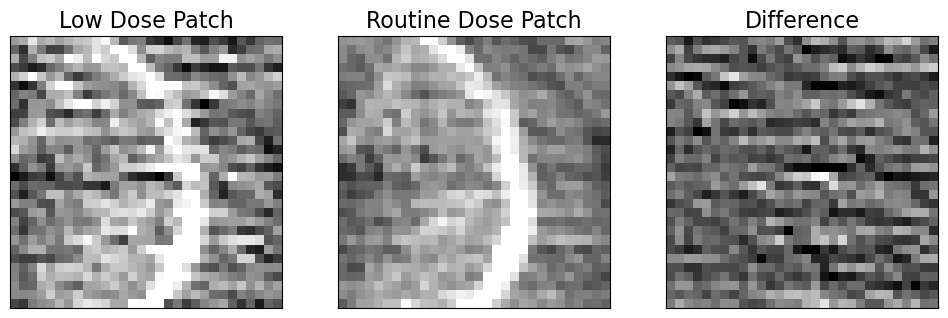

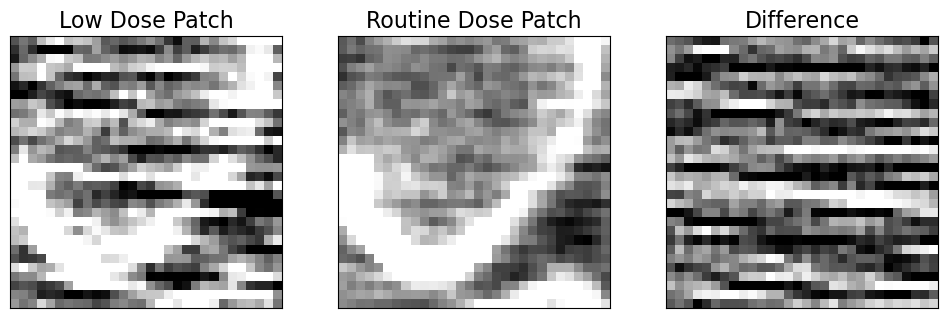

In [6]:
image_examples = [3, 16, 36]
window = 'soft_tissue'

for row in range(2):

  plt.figure(figsize=(12, 12))
  nexample = image_examples[row]

  # Simulated low-dose example
  plt.subplot(3, 3, 1+row*3)
  plt.title('Low Dose Patch', fontsize=16)
  ctshow(train_input[nexample, :, :, 0], window=window)

  # Simulated routine-dose example
  plt.subplot(3, 3, 2+row*3)
  plt.title('Routine Dose Patch', fontsize=16)
  ctshow(train_target[nexample, :, :, 0], window=window)
  plt.subplot(3, 3, 3+row*3)

  # Difference between low-dose and routine-dose to visualize CT noise
  plt.title('Difference', fontsize=16)
  ctshow(train_target[nexample, :, :, 0] - train_input[nexample, :, :, 0],
           window=window)

In [7]:
n_layers = 6
filters = 64
kernel_size = (3, 3)
strides = (1, 1)
activation = 'relu'

def build_model():
    xin = keras.layers.Input(shape=(None, None, 1), name='input_CT_images')
    # We define a preprocessing layer to rescale the CT image pixel values
    shift_mean = train_input.mean()
    rescale = train_input.std()
    x = keras.layers.Lambda(
        lambda x: (x - shift_mean) / rescale,
        name='normalization')(xin)

    for i in range(n_layers - 1):
        x = keras.layers.Conv2D(
          filters=filters,
          kernel_size=kernel_size,
          strides=strides,
          padding='same')(x)
        x = keras.layers.Activation(activation)(x)
    # Final layer has just one feature map corresponding to the output image
    x = keras.layers.Conv2D(
        filters=1,
        kernel_size=kernel_size,
        strides=strides,
        padding='same')(x)
    # Here we rescale the output to typical CT number range
    xout = keras.layers.Lambda(
        lambda x: (x * rescale) + shift_mean,
        name='output_CT_images')(x)
    # We define the model by specifying the inputand output tensors
    model = keras.Model(inputs=xin, outputs=xout, name="CT_denoiser")
    return model

In [8]:
noise_patch_dir = Path('../noise_patches')
# diameters = [112, 131, 151, 185, 200, 216, 292, 350]
# diameters = [151]
diameters = [112, 131]

noise_files = [noise_patch_dir / f'diameter{d}mm.npy' for d in diameters]
noise_patch_dict = {f.stem: np.load(f) for f in noise_files}
noise_patches = np.concatenate(list(noise_patch_dict.values()))
# noise_patches = np.zeros_like(noise_patches)

In [9]:
def load_noise_patch_dict(diameters = [112, 131, 151, 185, 216, 292, 350]):
    noise_files = [noise_patch_dir / f'diameter{d}mm.npy' for d in diameters]
    return {f.stem: np.load(f) for f in noise_files}
    
def load_noise_patches(diameters=[112, 131, 151, 185, 216, 292, 350]):
    noise_patch_dict = load_noise_patch_dict(diameters)
    return np.concatenate(list(noise_patch_dict.values()))

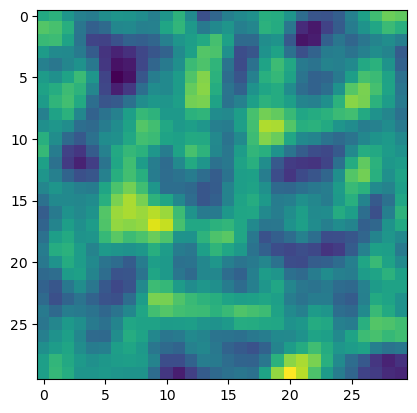

In [10]:
patches = load_noise_patches([112])
plt.imshow(noise_patches[0])

In [11]:
import sys
sys.path.append('..')
from nps_utils import compute_nps

Look at the average NPS of all the patches

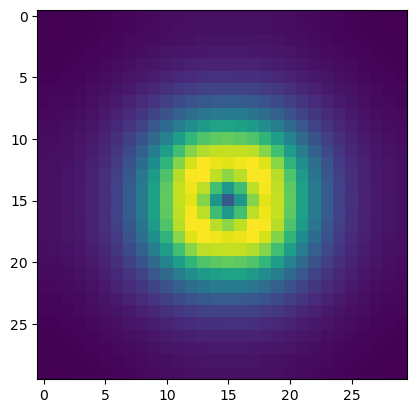

In [12]:
patches = load_noise_patches()
nps = compute_nps(patches)
plt.imshow(nps)

In [13]:
len(patches)

420000

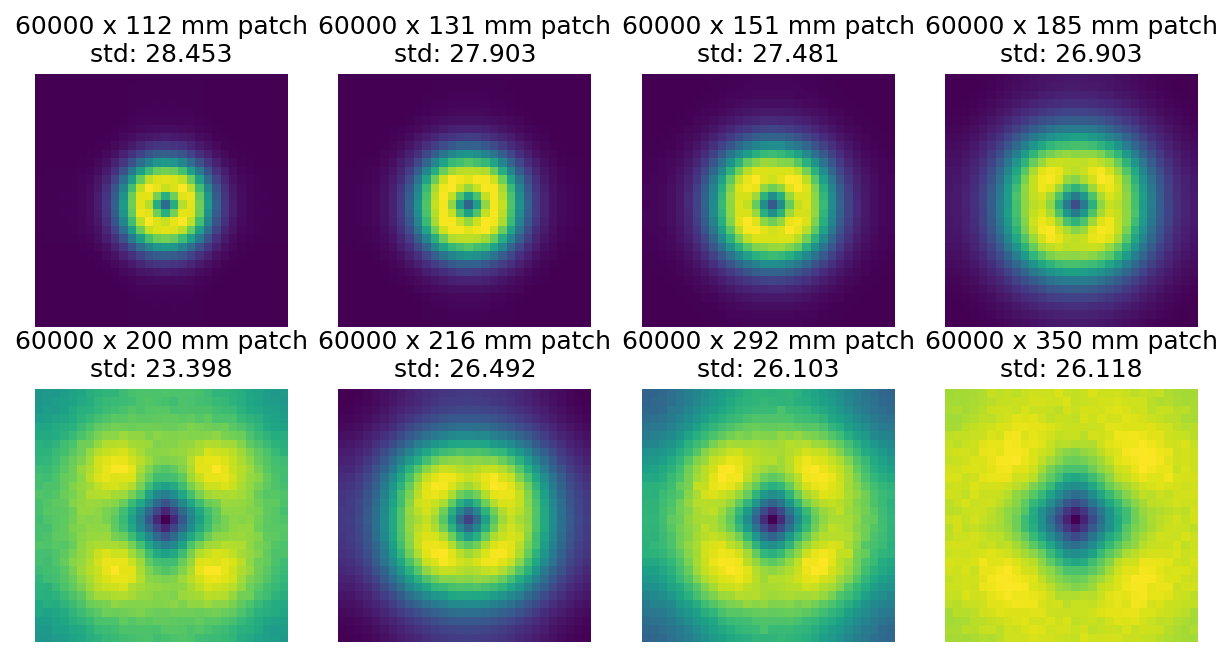

In [14]:
diameters = [112, 131, 151, 185, 200, 216, 292, 350]
f, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 5), dpi=150)
for d, ax in zip(diameters, axs.flatten()):
    patches = load_noise_patches([d])
    nps = compute_nps(patches)
    ax.imshow(nps)
    ax.axis('off')
    ax.set_title(f'{len(patches)} x {d} mm patch\nstd: {patches.std():3.3f}')

## How does the noise level and NPS compare to the training, validation, and testing sets?

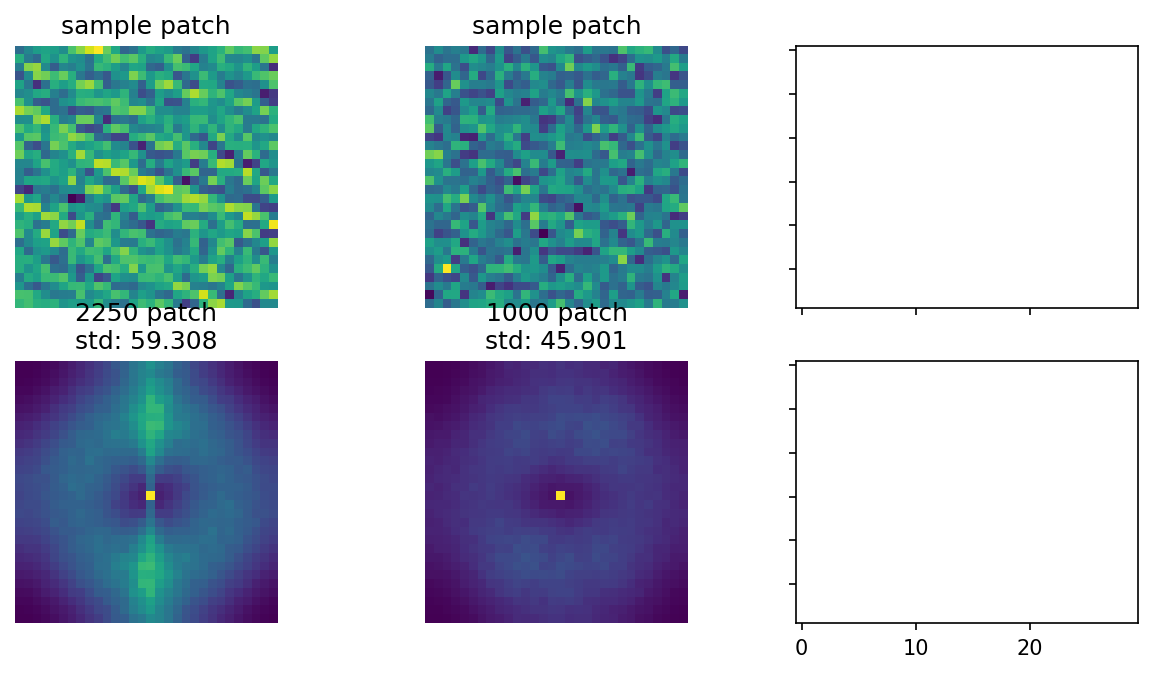

In [15]:
dset = [(train_input, train_target), (val_input, val_target)]
f, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 5), dpi=150)
for idx, d in enumerate(dset):
    patches = d[1] - d[0]
    nps = compute_nps(patches)
    axs[0, idx].imshow(patches[0])
    axs[0, idx].set_title('sample patch')
    axs[0, idx].axis('off')
    axs[1, idx].imshow(nps)
    axs[1, idx].axis('off')
    axs[1, idx].set_title(f'{len(patches)} patch\nstd: {patches.std():3.3f}')

In [16]:
# noise_patches = load_noise_patches([112, 131, 151, 185, 216, 292])
noise_patches = load_noise_patches([131])

In [17]:
noise_patches.std()

27.903005364865482

In [18]:
def get_dataset_std(input, target=None):
    if target is not None:
        return np.std(input - target)
    else:
        return np.std(input)

In [19]:
get_dataset_std(2*noise_patches)

55.806010729730964

In [20]:
get_dataset_std(train_input, train_target), get_dataset_std(val_input, val_target), get_dataset_std(test_input, test_target)

(59.30752, 45.900925, 32.779)

In [21]:
aug_thresh = 0.3
def augment(image_label, seed, max_noise=1):
  image, label = image_label
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  noise_patch = noise_patches[np.random.choice(list(range(len(noise_patches))))][:,:,None]
  noise_lambda = tf.random.uniform([1], minval=0, maxval=max_noise)[0]
  add_noise = tf.random.uniform([1], minval=0, maxval=1) > aug_thresh #from 0.5

  if add_noise:
    image = label + noise_lambda*noise_patch
  return image, label

Simpler augmentation block below

2023-09-06 13:21:07.409467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-06 13:21:07.426431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-06 13:21:07.427009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

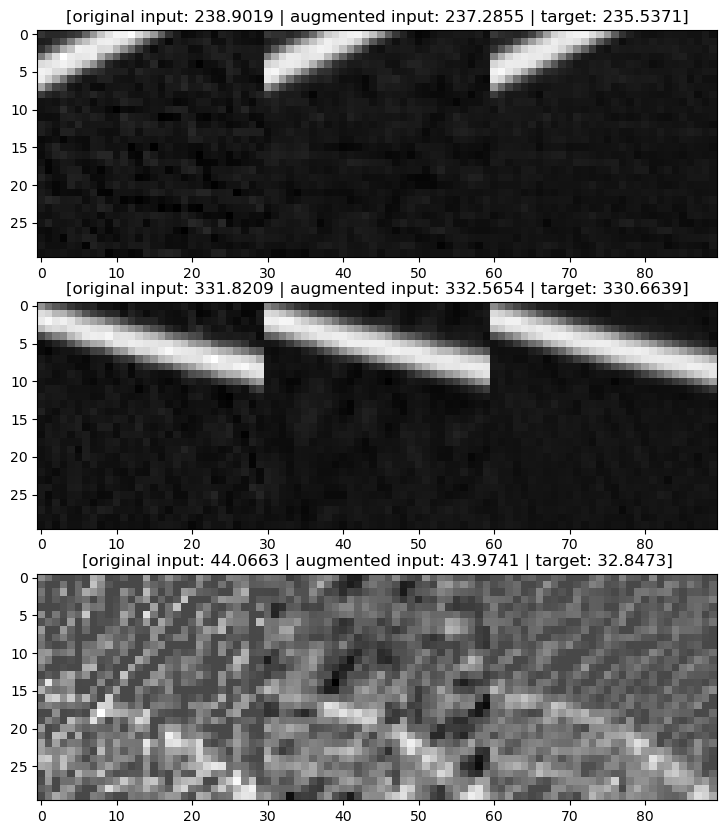

In [22]:
batch_size = 32
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

rng = tf.random.Generator.from_seed(123, alg='philox')
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(3):
    img = np.squeeze(images[i])
    aug_image = np.squeeze(f(images[i], labels[i])[0])
    lbl = np.squeeze(labels[i])
    diff = aug_image - img

    axs[i].imshow(np.concatenate([img, aug_image, lbl], axis=1), cmap='gray')
    axs[i].set_title(f'[original input: {img.std():0.4f} | augmented input: {aug_image.std():0.4f} | target: {lbl.std():0.4f}]')

I like it when it clearly adds a chunky noise on top, that lowe  frequency is what I want to train it ro remove

In [23]:
example_input = test_input[[3], ...]
edge_buffer = 128
progress_ims = []
progress_val = []

class SaveSampleImageCallback(keras.callbacks.Callback):
    def __init__(self, progress_ims, progress_val):
          super().__init__()
          self.progress_ims = progress_ims
          self.progress_val = progress_val
    def on_epoch_begin(self, epoch, logs=None):
            val_loss = self.model.evaluate(val_input, val_target)
            example_output = self.model.predict(example_input)
            example_img = example_output[0, edge_buffer:-edge_buffer,
                                         edge_buffer:-edge_buffer, 0]
            self.progress_ims.append(example_img)
            self.progress_val.append(val_loss)


In [24]:
def denoising_size_dependence(model, noise_patch_dict, N=None):
    N = N or len(noise_patch_dict['diameter112mm'])
    return {name: 100*(model.predict(patch_set[:N,:,:,None]).std()-patch_set[:N,:,:,None].std())/patch_set[:N,:,:,None].std() for name, patch_set in noise_patch_dict.items()}
noise_patch_dict = load_noise_patch_dict(diameters = [112, 131, 151, 185, 216, 292, 350])

In [25]:
noise_patch_dict['diameter131mm'][:,:,:,None].shape

(60000, 30, 30, 1)

In [26]:
val_input = noise_patch_dict['diameter131mm'][:1000,:,:,None]
val_target = np.zeros_like(val_input)
val_input.shape, val_target.shape

((1000, 30, 30, 1), (1000, 30, 30, 1))

In [27]:
import datetime
from tensorflow.keras.metrics import RootMeanSquaredError

rng = tf.random.Generator.from_seed(123, alg='philox')
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

# This sets the number of iterations through the training data
epochs = 15
batch_size = 32
learning_rate = 0.0001
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer = 'adam'

train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

AUTOTUNE = tf.data.AUTOTUNE

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

def train(augment_training=False, model=None, epochs=15):
  'providing `model` as an argument skips model building and compiling and allows fine-tuning with a pretrained model'
  train_ds = (
      train_dataset
      .map(f, num_parallel_calls=AUTOTUNE)
      .prefetch(AUTOTUNE)
  ) if augment_training else (
      train_dataset
      .prefetch(AUTOTUNE)
  )
  if model is None:
    model = build_model()
    model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
  progress_ims = []
  progress_val = []
  callback = SaveSampleImageCallback(progress_ims, progress_val)
  model.fit(train_ds, epochs = epochs, callbacks=[callback, tensorboard_callback], validation_data=val_dataset)

  progress_ims = np.stack(progress_ims, axis=0)

  print('Training phase complete.')
  return model, np.stack(callback.progress_ims, axis=0), callback.progress_val

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

base_denoising_model, base_progress_ims, base_progress_val = train(augment_training=False, epochs=15)

2023-09-06 13:22:33.738468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


1/1 [==============================] - 0s 114ms/step
Epoch 1/15


2023-09-06 13:22:35.097323: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faa4e5bbdd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-06 13:22:35.097345: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-09-06 13:22:35.100080: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-06 13:22:35.186879: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 0s 10ms/step
Epoch 2/15
1/1 [==============================] - 0s 10ms/step
Epoch 3/15
1/1 [==============================] - 0s 10ms/step
Epoch 4/15
1/1 [==============================] - 0s 13ms/step
Epoch 5/15
1/1 [==============================] - 0s 9ms/step
Epoch 6/15
1/1 [==============================] - 0s 9ms/step
Epoch 7/15
1/1 [==============================] - 0s 9ms/step
Epoch 8/15
1/1 [==============================] - 0s 9ms/step
Epoch 9/15
1/1 [==============================] - 0s 11ms/step
Epoch 10/15
1/1 [==============================] - 0s 9ms/step
Epoch 11/15
1/1 [==============================] - 0s 9ms/step
Epoch 12/15
1/1 [==============================] - 0s 9ms/step
Epoch 13/15
1/1 [==============================] - 0s 10ms/step
Epoch 14/15
1/1 [==============================] - 0s 9ms/step
Epoch 15/15
71/71 [==============================] - 1s 19ms/step - loss: 811.5661 - root_mean_squared_error: 28.4880 - val_loss: 12

In [29]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [30]:
def check_progress_ims(progress_ims):
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 2, 1)
    plt.title('Before Optimization', fontsize=16)
    ctshow(progress_ims[0, :, :], window='variable')

    plt.subplot(2, 2, 2)
    plt.title('Epoch %d/%d' %(1, epochs), fontsize=16)
    ctshow(progress_ims[1, :, :], window='soft_tissue')

    plt.subplot(2, 2, 3)
    plt.title('Epoch %d/%d' %(5, epochs), fontsize=16)
    ctshow(progress_ims[5, :, :], window='soft_tissue')

    plt.subplot(2, 2, 4)
    plt.title('Final Epoch', fontsize=16)
    ctshow(progress_ims[-1, :, :], window='soft_tissue')

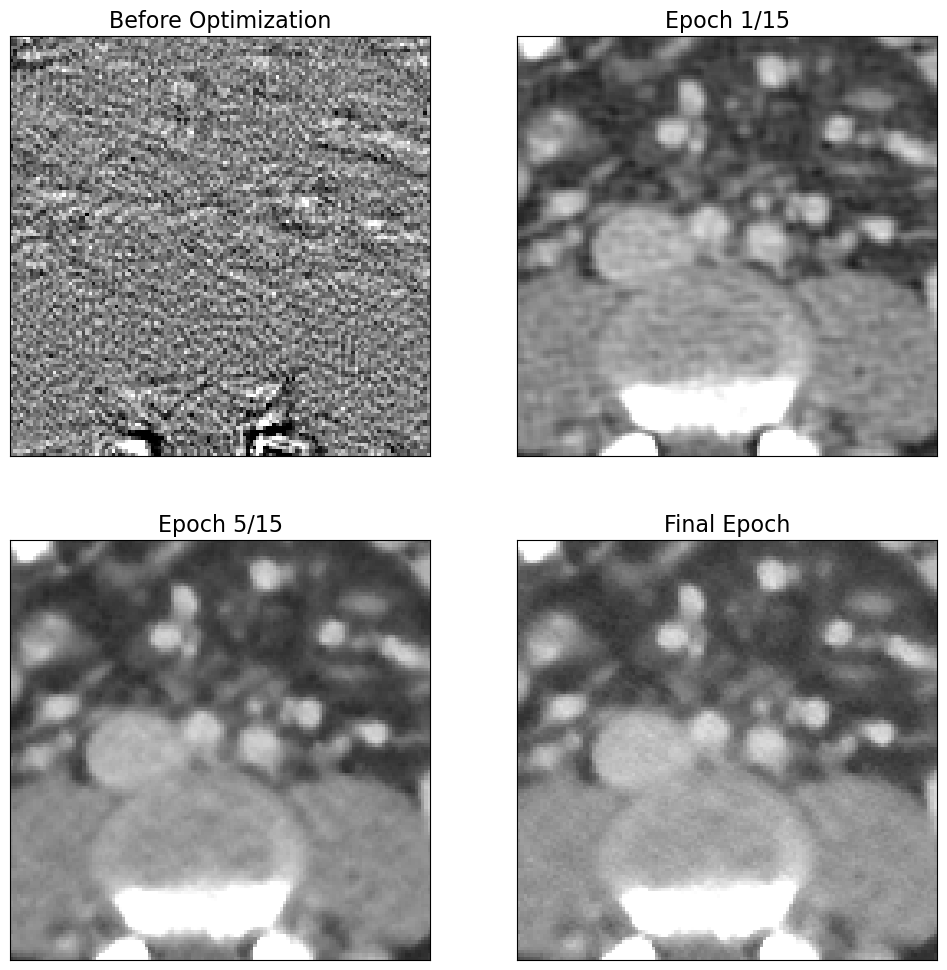

In [31]:
check_progress_ims(base_progress_ims)

## Now with augmentation

In [32]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

aug_denoising_model, aug_progress_ims, aug_progress_val = train(augment_training=True, epochs=100)

1/1 [==============================] - 0s 44ms/step
Epoch 1/100
1/1 [==============================] - 0s 11ms/step
Epoch 2/100
1/1 [==============================] - 0s 10ms/step
Epoch 3/100
1/1 [==============================] - 0s 9ms/step
Epoch 4/100
1/1 [==============================] - 0s 11ms/step
Epoch 5/100
1/1 [==============================] - 0s 9ms/step
Epoch 6/100
1/1 [==============================] - 0s 9ms/step
Epoch 7/100
1/1 [==============================] - 0s 11ms/step
Epoch 8/100
1/1 [==============================] - 0s 10ms/step
Epoch 9/100
1/1 [==============================] - 0s 10ms/step
Epoch 10/100
1/1 [==============================] - 0s 9ms/step
Epoch 11/100
1/1 [==============================] - 0s 9ms/step
Epoch 12/100
1/1 [==============================] - 0s 9ms/step
Epoch 13/100
1/1 [==============================] - 0s 9ms/step
Epoch 14/100
1/1 [==============================] - 0s 9ms/step
Epoch 15/100
1/1 [==============================] - 0s 

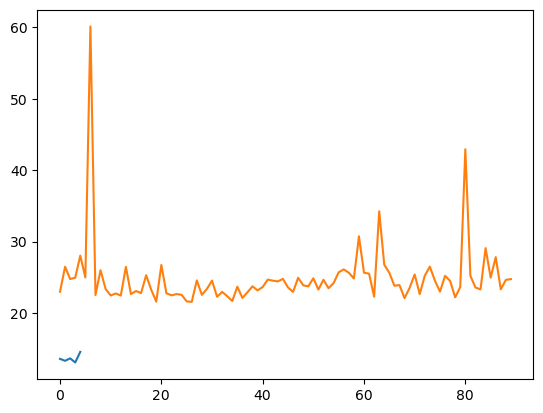

In [33]:
plt.plot(np.array(base_progress_val)[10:, 1],label='cnn')
plt.plot(np.array(aug_progress_val)[10:, 1],label='aug')
plt.show()

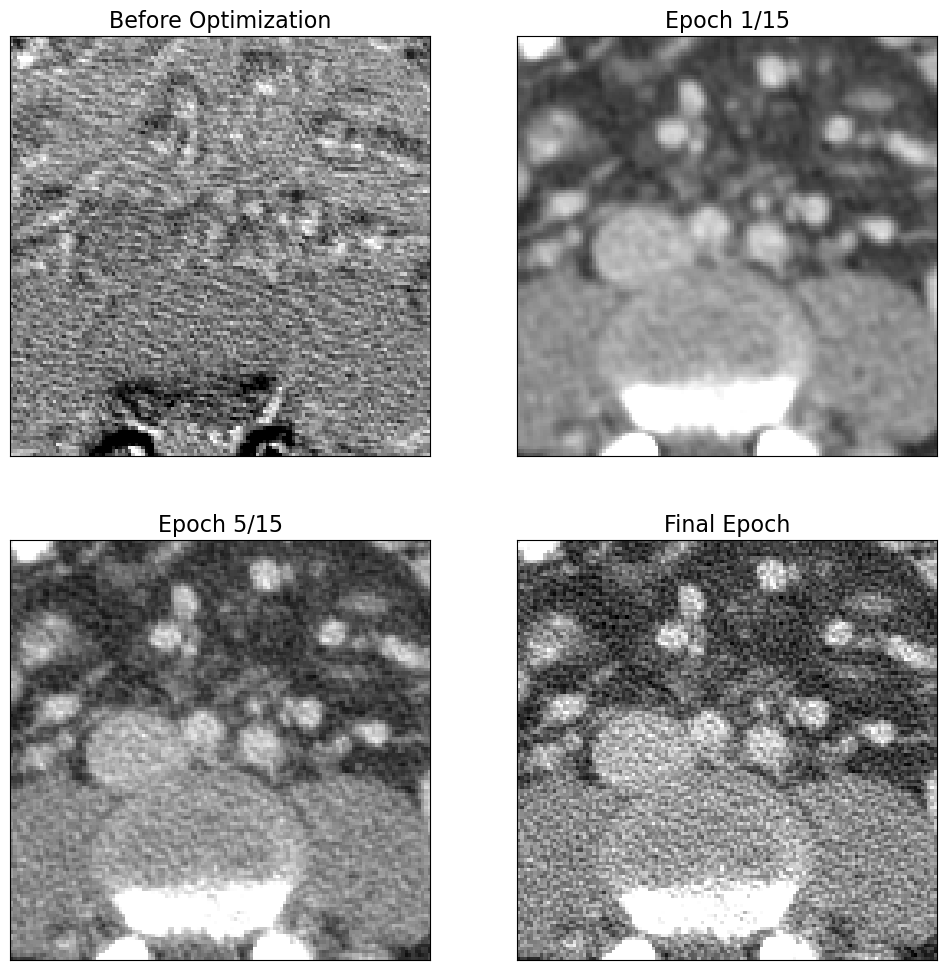

In [34]:
check_progress_ims(aug_progress_ims)

7/7 [==============================] - 0s 3ms/step


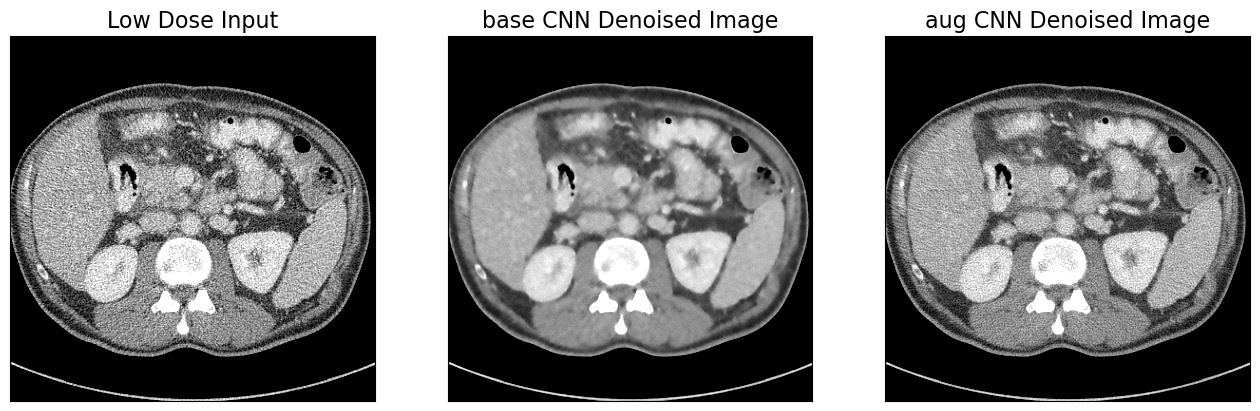

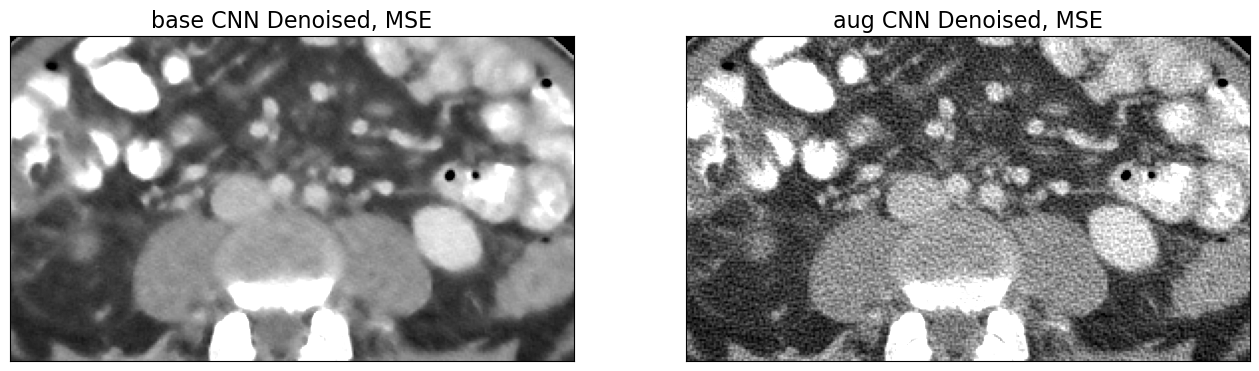

In [35]:
nexample = 2
base_CNNout = base_denoising_model.predict(test_input, batch_size=1)
aug_CNNout = aug_denoising_model.predict(test_input, batch_size=1)

plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[nexample, :, :, 0])


plt.subplot(1, 3, 2)
plt.title('base CNN Denoised Image', fontsize=16)
ctshow(base_CNNout[nexample, :, :, 0])

plt.subplot(1, 3, 3)
plt.title('aug CNN Denoised Image', fontsize=16)
ctshow(aug_CNNout[nexample, :, :, 0])

# Same as above, but with a different field of view
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('base CNN Denoised, MSE', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50, 0])

plt.subplot(1, 2, 2)
plt.title('aug CNN Denoised, MSE', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50, 0])

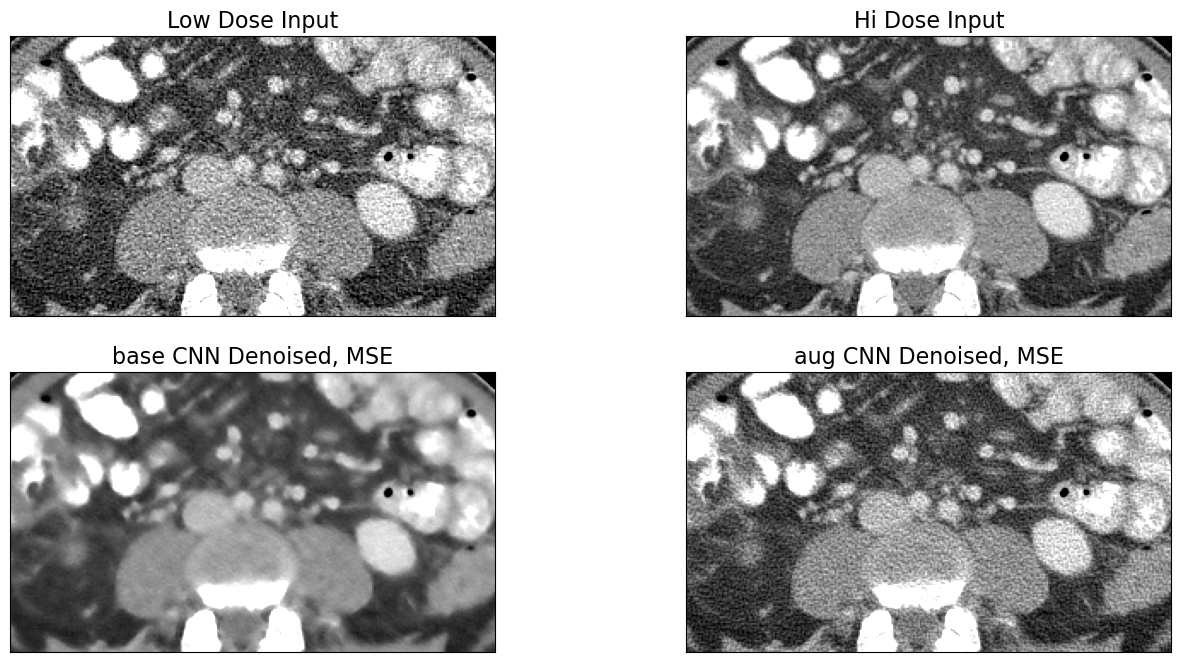

In [36]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 2)
plt.title('Hi Dose Input', fontsize=16)
ctshow(test_target[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 3)
plt.title('base CNN Denoised, MSE', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 4)
plt.title('aug CNN Denoised, MSE', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50, 0])
# plt.savefig(f'comp_{aug_thresh:0.1f}.png', dpi=150)

Interesting, adding more augmentaton by lowering that threshold reduces overall denoising but improves retention of texture, see how this compares to simply adding back noise to the un-augmented cnn

So far it seems like if I add too much low frequency noise, it destroy  the training and leavee our high frequenices, so I nee to balance the weighting about how many of the traingin images have augmentation while having enough noise reduction

There's a balance between *how much* denoiosing and what frequencies to remove, so it seems like there's 2 parameters to balance

Seems like higher frequency (lower threshold) --> more augmentation and thus lower overall noise reduction, but with better texture

In [37]:
print("Evaluate")
result = base_denoising_model.evaluate(test_dataset)
dict(zip(base_denoising_model.metrics_names, result))

Evaluate
1/1 [==============================] - 1s 1s/step - loss: 588.1197 - root_mean_squared_error: 24.2512


{'loss': 588.1196899414062, 'root_mean_squared_error': 24.251178741455078}

In [38]:
result = aug_denoising_model.evaluate(test_dataset)
dict(zip(aug_denoising_model.metrics_names, result))

1/1 [==============================] - 0s 77ms/step - loss: 729.3593 - root_mean_squared_error: 27.0067


{'loss': 729.3593139648438, 'root_mean_squared_error': 27.00665283203125}

## Now Data Augmentation as a Fine Tuning Step

Take the pretrained `Simple CNN MSE` then apply the data augmentation. In theory it already knows how to denoise. Will fine tuning be destructive or improve generalizability to more textures?

In [39]:
aug_pretrained_model, aug_pretrained_progress_ims, aug_pretrained_progress_val = train(augment_training=True, model=base_denoising_model, epochs=100)

1/1 [==============================] - 0s 9ms/step
Epoch 1/100
1/1 [==============================] - 0s 9ms/step
Epoch 2/100
1/1 [==============================] - 0s 9ms/step
Epoch 3/100
1/1 [==============================] - 0s 9ms/step
Epoch 4/100
1/1 [==============================] - 0s 9ms/step
Epoch 5/100
1/1 [==============================] - 0s 9ms/step
Epoch 6/100
1/1 [==============================] - 0s 9ms/step
Epoch 7/100
1/1 [==============================] - 0s 9ms/step
Epoch 8/100
1/1 [==============================] - 0s 9ms/step
Epoch 9/100
1/1 [==============================] - 0s 9ms/step
Epoch 10/100
1/1 [==============================] - 0s 9ms/step
Epoch 11/100
1/1 [==============================] - 0s 9ms/step
Epoch 12/100
1/1 [==============================] - 0s 10ms/step
Epoch 13/100
1/1 [==============================] - 0s 10ms/step
Epoch 14/100
1/1 [==============================] - 0s 10ms/step
Epoch 15/100
1/1 [==============================] - 0s 9ms/

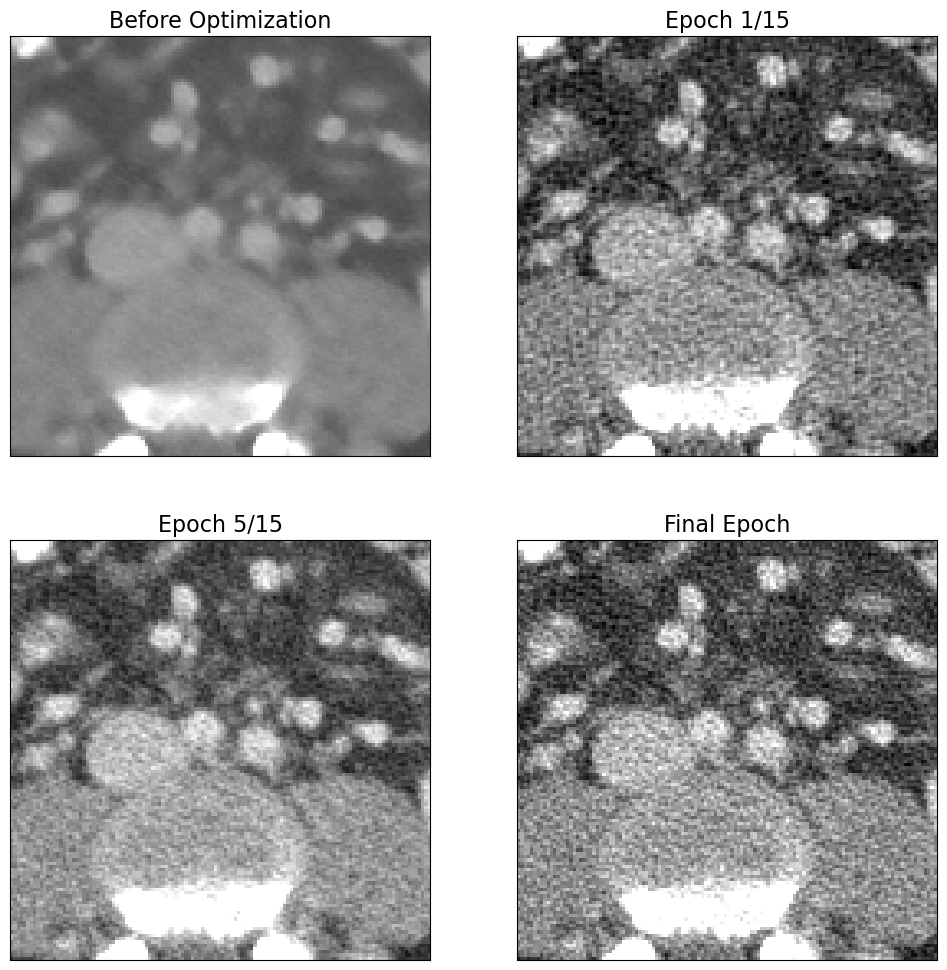

In [40]:
check_progress_ims(aug_pretrained_progress_ims)

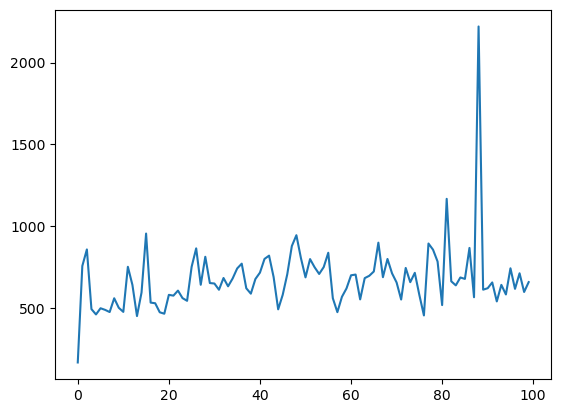

In [41]:
plt.plot(np.array(aug_pretrained_progress_val)[:,0])

7/7 [==============================] - 0s 4ms/step


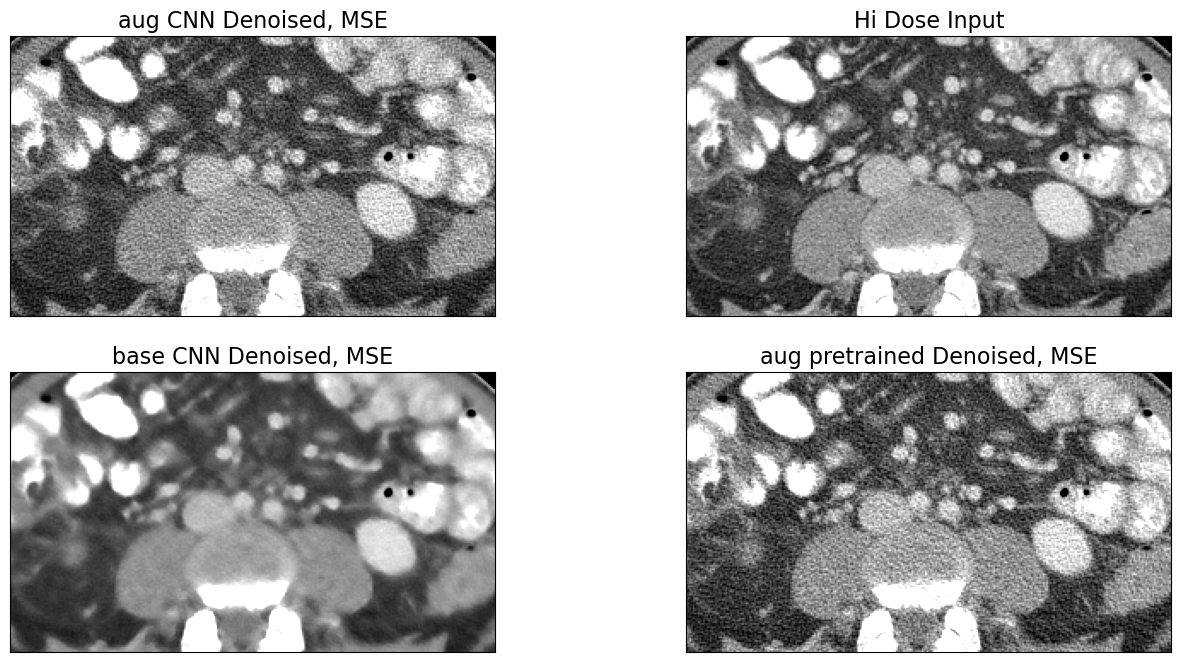

In [42]:
aug_pretrainedout = aug_pretrained_model.predict(test_input, batch_size=1)
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.title('aug CNN Denoised, MSE', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 2)
plt.title('Hi Dose Input', fontsize=16)
ctshow(test_target[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 3)
plt.title('base CNN Denoised, MSE', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 4)
plt.title('aug pretrained Denoised, MSE', fontsize=16)
ctshow(aug_pretrainedout[3, 110:-110, 50:-50, 0])

In [43]:
print("Evaluate")
result = base_denoising_model.evaluate(test_dataset)
dict(zip(base_denoising_model.metrics_names, result))

Evaluate
1/1 [==============================] - 0s 35ms/step - loss: 784.8468 - root_mean_squared_error: 28.0151


{'loss': 784.8468017578125, 'root_mean_squared_error': 28.015117645263672}

In [44]:
result = aug_denoising_model.evaluate(test_dataset)
dict(zip(aug_denoising_model.metrics_names, result))

1/1 [==============================] - 0s 38ms/step - loss: 729.3593 - root_mean_squared_error: 27.0067


{'loss': 729.3593139648438, 'root_mean_squared_error': 27.00665283203125}

In [45]:
result = aug_pretrained_model.evaluate(test_dataset)
dict(zip(aug_pretrained_model.metrics_names, result))

1/1 [==============================] - 0s 39ms/step - loss: 784.8468 - root_mean_squared_error: 28.0151


{'loss': 784.8468017578125, 'root_mean_squared_error': 28.015117645263672}